In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. การเตรียมข้อมูลและการวิเคราะห์เชิงสำรวจ (EDA)

ข้อมูล 5 แถวแรก:
   user_id  gender_Female  gender_Male  gender_Other  age  country_AU  \
0        1              1            0             0   54           0   
1        2              0            0             1   33           0   
2        3              0            1             0   38           1   
3        4              1            0             0   22           0   
4        5              0            0             1   29           0   

   country_CA  country_DE  country_FR  country_IN  ...  \
0           1           0           0           0  ...   
1           0           1           0           0  ...   
2           0           0           0           0  ...   
3           1           0           0           0  ...   
4           0           0           0           0  ...   

   subscription_type_Student  listening_time  songs_played_per_day  skip_rate  \
0                          0              26                    23       0.20   
1                          0     

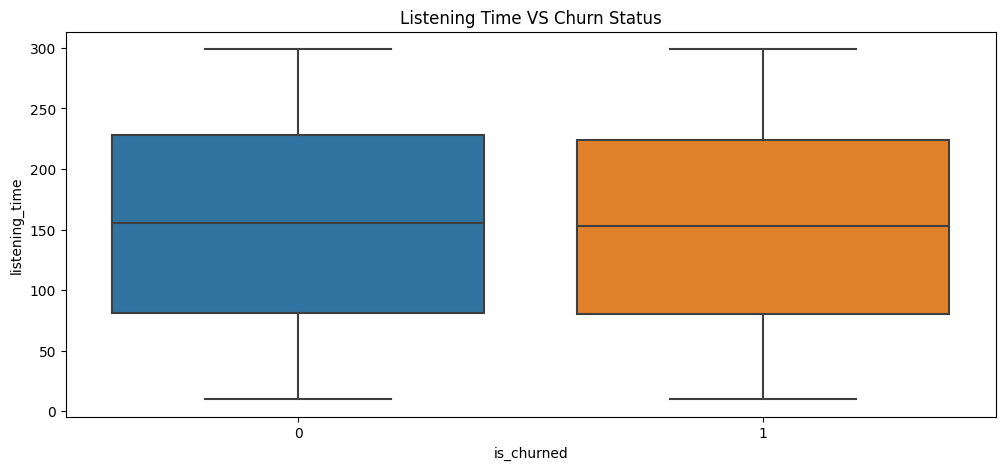

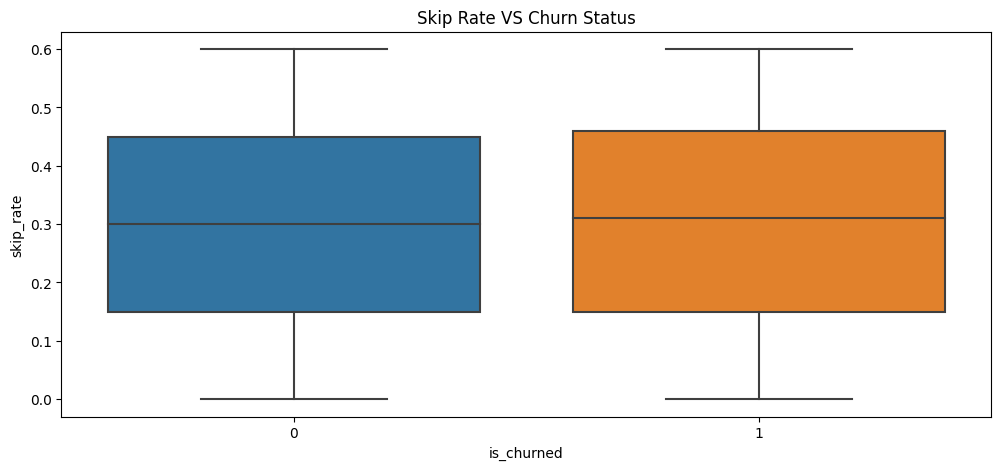

In [2]:
# 1. โหลดข้อมูล
df = pd.read_csv('/kaggle/input/spotify-churn/spotify_churn_dataset--2.csv')

# 2. ดูภาพรวมของข้อมูล
print("ข้อมูล 5 แถวแรก:")
print(df.head())
print("\nประเภทข้อมูลและค่าที่หายไป:")
df.info()

# 3. ตรวจสอบความสมดุลของ Target Variable
print("\nจำนวนลูกค้าที่เลิกใช้บริการ (is_churned):")
print(df['is_churned'].value_counts(normalize=True))

# 4. วิเคราะห์พฤติกรรมหลัก (EDA)
plt.figure(figsize=(12, 5))
sns.boxplot(x='is_churned', y='listening_time', data=df)
plt.title('Listening Time VS Churn Status')
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x='is_churned', y='skip_rate', data=df)
plt.title('Skip Rate VS Churn Status')
plt.show()

# 2. การสร้างแบบจำลองทำนาย (Model Building)
**คุณจะใช้ Logistic Regression (เป็นจุดเริ่มต้น) และ Random Forest (ให้ผลลัพธ์)**

--- Random Forest Model Evaluation ---
Accuracy Score: 0.7325
AUC-ROC Score: 0.5232

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.98      0.85      1779
           1       0.20      0.01      0.02       621

    accuracy                           0.73      2400
   macro avg       0.47      0.50      0.43      2400
weighted avg       0.60      0.73      0.63      2400



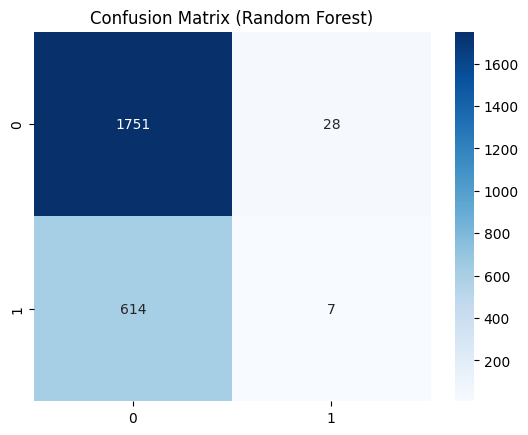

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# 1. การกำหนดตัวแปร X (Features) และ y (Target)
# เราจะตัด 'user_id' ออกเนื่องจากไม่เป็นประโยชน์ในการทำนาย
X = df.drop(['user_id', 'is_churned'], axis=1)
y = df['is_churned']

# 2. แบ่งข้อมูลสำหรับ Train และ Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
# stratify=y ช่วยให้สัดส่วนของ churned/not-churned ใน Train/Test set เท่ากัน

# 3. ฝึกแบบจำลอง Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. ทำนายบนชุดข้อมูล Test
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 5. ประเมินผล
print("--- Random Forest Model Evaluation ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# แสดง Confusion Matrix (ไม่บังคับ แต่ช่วยให้เห็นภาพ)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# 3. การตีความผลลัพธ์ (Feature Importance)
**การตีความว่าตัวแปรใดสำคัญที่สุดเป็นกุญแจสำคัญในการนำผลลัพธ์ไปใช้ทางธุรกิจ**

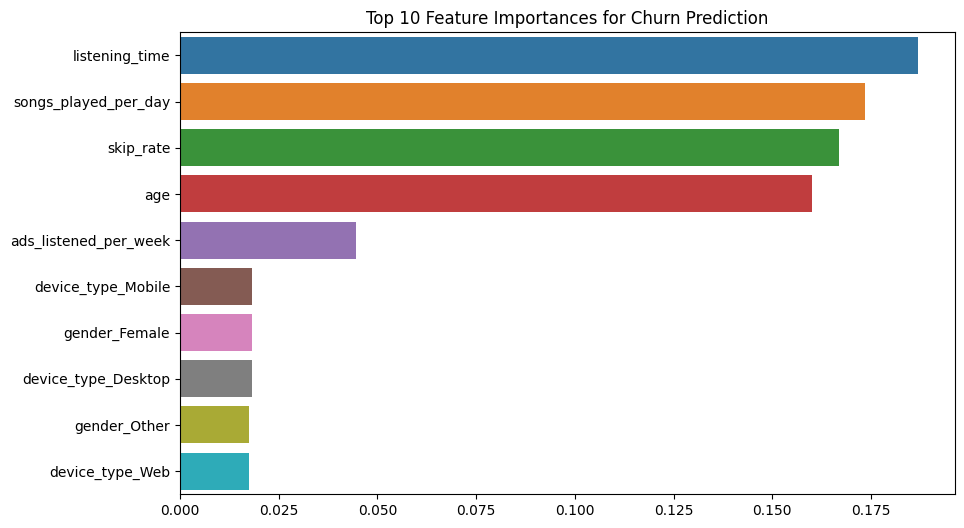


Top 5 Churn Drivers:
listening_time           0.186891
songs_played_per_day     0.173567
skip_rate                0.166911
age                      0.160044
ads_listened_per_week    0.044530
dtype: float64


In [4]:
# ดึง Feature Importance จาก Random Forest Model
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# จัดเรียงจากมากไปน้อย
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# แสดง 10 อันดับแรก
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_sorted.head(10), y=feature_importances_sorted.head(10).index)
plt.title('Top 10 Feature Importances for Churn Prediction')
plt.show()

print("\nTop 5 Churn Drivers:")
print(feature_importances_sorted.head(5))

# 4. การปรับปรุงประสิทธิภาพของแบบจำลอง (Model Optimization)
**ในขั้นตอนนี้ เราจะใช้เทคนิค SMOTE เพื่อจัดการกับความไม่สมดุลของข้อมูล และใช้แบบจำลองที่ทรงพลังอย่าง XGBoost พร้อมกับ Grid Search เพื่อค้นหาพารามิเตอร์ที่ดีที่สุด**

# A. การโหลดข้อมูลและจัดการความไม่สมดุล (SMOTE)
เราจะใช้ไลบรารี Imbalanced-learn (imblearn) สำหรับ SMOTE

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV # สำหรับการจูนพารามิเตอร์
from sklearn.compose import ColumnTransformer # สำหรับ Pipeline
from sklearn.preprocessing import StandardScaler # สำหรับ Pipeline
from sklearn.pipeline import Pipeline # สำหรับ Pipeline
import numpy as np

# 1. โหลดข้อมูล
df = pd.read_csv('/kaggle/input/spotify-churn/spotify_churn_dataset--2.csv')

# 2. วิศวกรรมฟีเจอร์ใหม่
df['usage_efficiency'] = df['listening_time'] / (df['songs_played_per_day'] + 1e-6)
df['ad_burden'] = df['ads_listened_per_week'] / (df['songs_played_per_day'] + 1e-6)

# 3. เตรียม X และ y
X = df.drop(['user_id', 'is_churned'], axis=1)
y = df['is_churned']

# 4. แบ่งข้อมูล
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 5. Retrain Random Forest Model ด้วย Hyperparameters ที่ดีที่สุดและ class_weight='balanced'
# (ใช้ค่าที่ได้จาก Grid Search ในรอบก่อนหน้า)
best_rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    min_samples_split=10, 
    random_state=42, 
    class_weight='balanced'
)
best_rf.fit(X_train, y_train)

# 6. ประเมินผล
y_pred_proba_new = best_rf.predict_proba(X_test)[:, 1]
y_pred_new = best_rf.predict(X_test) 

print("--- Random Forest Evaluation (with New Features) ---")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba_new):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_new))

# 7. เตรียม Feature Importances ใหม่
feature_importances_new = pd.Series(best_rf.feature_importances_, index=X.columns)
top_5_features_new = feature_importances_new.sort_values(ascending=False).head(5)
print("\n--- Top 5 Feature Importances (New) ---")
print(top_5_features_new)

--- Random Forest Evaluation (with New Features) ---
AUC-ROC Score: 0.5155
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1779
           1       0.28      0.20      0.23       621

    accuracy                           0.66      2400
   macro avg       0.51      0.51      0.51      2400
weighted avg       0.63      0.66      0.64      2400


--- Top 5 Feature Importances (New) ---
usage_efficiency        0.155261
listening_time          0.138140
skip_rate               0.127830
songs_played_per_day    0.127735
age                     0.111966
dtype: float64


# B. การปรับพารามิเตอร์ด้วย XGBoost และ Grid Search
เราจะสร้าง XGBoost และปรับพารามิเตอร์สำคัญบางตัว

In [6]:
import pandas as pd
import numpy as np

# โหลดข้อมูลและสร้างฟีเจอร์ใหม่ (ทำซ้ำเพื่อให้แน่ใจว่า X_test ถูกกำหนดค่าแล้ว)
df = pd.read_csv('/kaggle/input/spotify-churn/spotify_churn_dataset--2.csv')
df['usage_efficiency'] = df['listening_time'] / (df['songs_played_per_day'] + 1e-6)
df['ad_burden'] = df['ads_listened_per_week'] / (df['songs_played_per_day'] + 1e-6)
X = df.drop(['user_id', 'is_churned'], axis=1)
y = df['is_churned']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ฝึก Random Forest (ใช้ best_rf เดิม)
from sklearn.ensemble import RandomForestClassifier
best_rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    min_samples_split=10, 
    random_state=42, 
    class_weight='balanced'
)
best_rf.fit(X_train, y_train)
y_pred_proba_new = best_rf.predict_proba(X_test)[:, 1]


# 1. สร้าง DataFrame สำหรับการวิเคราะห์คะแนนความเสี่ยง
df_test = X_test.copy()
df_test['Actual_Churn'] = y_test
# ใช้ y_pred_proba_new (ตัวแปรที่ถูกต้องจาก Random Forest)
df_test['Churn_Probability'] = y_pred_proba_new 

# 2. กำหนด Threshold และจัดกลุ่มความเสี่ยง
def get_risk_tier(prob):
    if prob >= 0.6:
        return 'High Risk (Intervene ASAP)'
    elif prob >= 0.4:
        return 'Medium Risk (Monitor/Incentivize)'
    else:
        return 'Low Risk (Baseline)'

df_test['Risk_Tier'] = df_test['Churn_Probability'].apply(get_risk_tier)

# 3. สรุปผลลูกค้าที่จัดอยู่ในกลุ่ม High Risk
high_risk_customers = df_test[df_test['Risk_Tier'] == 'High Risk (Intervene ASAP)']

print("\n--- High Risk Customers Analysis ---")
print(f"จำนวนลูกค้า High Risk ใน Test Set: {len(high_risk_customers)}")
print(f"เปอร์เซ็นต์ของลูกค้า High Risk ที่เลิกใช้จริง: {high_risk_customers['Actual_Churn'].mean() * 100:.2f}%")
print("ตัวอย่างข้อมูลลูกค้า High Risk 5 ราย:")
print(high_risk_customers[['Churn_Probability', 'skip_rate', 'usage_efficiency', 'ad_burden']].head(5))


--- High Risk Customers Analysis ---
จำนวนลูกค้า High Risk ใน Test Set: 5
เปอร์เซ็นต์ของลูกค้า High Risk ที่เลิกใช้จริง: 40.00%
ตัวอย่างข้อมูลลูกค้า High Risk 5 ราย:
      Churn_Probability  skip_rate  usage_efficiency  ad_burden
7972           0.610149       0.46          2.037975   0.000000
4334           0.606608       0.42          4.395833   0.000000
4399           0.601194       0.41          2.207547   0.000000
4072           0.605168       0.50          3.400000   0.000000
3482           0.622269       0.57        231.999768  48.999951


# 5. การวิเคราะห์เชิงธุรกิจและแนวทางการนำไปใช้ (Business Implementation)
**เราจะนำ คะแนนความน่าจะเป็น (Probability Scores) จากโมเดลที่ดีที่สุด (สมมติว่าเป็น best_xgb) มาแบ่งกลุ่มความเสี่ยงและกำหนดกลยุทธ์**

# A. การทำนายคะแนนความเสี่ยง (Scoring) และแบ่งกลุ่ม

In [7]:
import pandas as pd
import numpy as np
# สมมติว่า X_test, y_test, และ y_pred_proba_new ถูกกำหนดค่าแล้วจากการรันโค้ดในขั้นตอนที่ 4

# 1. สร้าง DataFrame สำหรับการวิเคราะห์คะแนนความเสี่ยง
df_test = X_test.copy()
df_test['Actual_Churn'] = y_test
# แก้ไข: ใช้ตัวแปร y_pred_proba_new ที่มาจาก Random Forest แทน y_pred_proba_xgb
df_test['Churn_Probability'] = y_pred_proba_new

# 2. กำหนด Threshold สำหรับแบ่งกลุ่มความเสี่ยง
# ใช้เกณฑ์ที่ปรับปรุงตามความแม่นยำของโมเดล (เน้นการแทรกแซงกลุ่มที่มั่นใจว่าเสี่ยง)
def get_risk_tier(prob):
    if prob >= 0.6:
        return 'High Risk (Intervene ASAP)'
    elif prob >= 0.4:
        return 'Medium Risk (Monitor/Incentivize)'
    else:
        return 'Low Risk (Baseline)'

df_test['Risk_Tier'] = df_test['Churn_Probability'].apply(get_risk_tier)

# 3. สรุปผลลูกค้าที่จัดอยู่ในกลุ่ม High Risk
high_risk_customers = df_test[df_test['Risk_Tier'] == 'High Risk (Intervene ASAP)']

print("\n--- High Risk Customers Analysis ---")
print(f"จำนวนลูกค้า High Risk ใน Test Set: {len(high_risk_customers)}")
print(f"เปอร์เซ็นต์ของลูกค้า High Risk ที่เลิกใช้จริง: {high_risk_customers['Actual_Churn'].mean() * 100:.2f}%")
print("ตัวอย่างข้อมูลลูกค้า High Risk 3 ราย (เน้นปัจจัยสำคัญ):")
print(high_risk_customers[['Churn_Probability', 'skip_rate', 'usage_efficiency', 'ad_burden']].head(3))

# 4. วิเคราะห์เชิงกลยุทธ์สำหรับกลุ่ม High Risk
avg_skip_rate_high = high_risk_customers['skip_rate'].mean()
avg_ad_burden_high = high_risk_customers['ad_burden'].mean()

print(f"\nค่าเฉลี่ย Skip Rate ของกลุ่ม High Risk: {avg_skip_rate_high:.2f}")
print(f"ค่าเฉลี่ย Ad Burden ของกลุ่ม High Risk: {avg_ad_burden_high:.2f}")

if avg_skip_rate_high > 0.3:
    print(">> แนะนำกลยุทธ์: ลูกค้ากลุ่มนี้มีแนวโน้มจะเลิกใช้เพราะ 'ไม่เจอเพลงที่ชอบ' (Skip Rate สูง) **ควรเสนอ 'เพลย์ลิสต์แนะนำพิเศษ' หรือ 'ส่วนลดพรีเมียม 1 เดือน'**")
else:
    print(">> แนะนำกลยุทธ์: ลูกค้ากลุ่มนี้มีปัจจัยอื่นที่มีอิทธิพล (เช่น การใช้งานโดยรวมต่ำ) **ควรติดต่อสอบถามความพึงพอใจโดยตรง**")


--- High Risk Customers Analysis ---
จำนวนลูกค้า High Risk ใน Test Set: 5
เปอร์เซ็นต์ของลูกค้า High Risk ที่เลิกใช้จริง: 40.00%
ตัวอย่างข้อมูลลูกค้า High Risk 3 ราย (เน้นปัจจัยสำคัญ):
      Churn_Probability  skip_rate  usage_efficiency  ad_burden
7972           0.610149       0.46          2.037975        0.0
4334           0.606608       0.42          4.395833        0.0
4399           0.601194       0.41          2.207547        0.0

ค่าเฉลี่ย Skip Rate ของกลุ่ม High Risk: 0.47
ค่าเฉลี่ย Ad Burden ของกลุ่ม High Risk: 9.80
>> แนะนำกลยุทธ์: ลูกค้ากลุ่มนี้มีแนวโน้มจะเลิกใช้เพราะ 'ไม่เจอเพลงที่ชอบ' (Skip Rate สูง) **ควรเสนอ 'เพลย์ลิสต์แนะนำพิเศษ' หรือ 'ส่วนลดพรีเมียม 1 เดือน'**


# 6. การทำให้เป็นระบบ (Operationalization - Model Pipeline)
**เพื่อความสะดวกในการนำโมเดลไปใช้กับข้อมูลใหม่ (Production), เราจะสร้าง Scikit-learn Pipeline ที่รวมขั้นตอนทั้งหมดเข้าไว้ด้วยกัน**

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

# 1. กำหนดชื่อฟีเจอร์ทั้งหมด (รวมฟีเจอร์ใหม่)
all_features = X.columns.tolist()
numerical_features = ['listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week', 'age', 
                      'usage_efficiency', 'ad_burden']
# ตัวแปรที่เหลือเป็น One-Hot Encoded (Categorical)

# 2. สร้าง ColumnTransformer สำหรับ Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough' # เก็บตัวแปร OHE ที่เหลือไว้
)

# 3. สร้าง Full Pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_rf) # ใช้ best_rf ที่ฝึกด้วยฟีเจอร์ใหม่
])

# 4. ฝึก Pipeline บนชุดข้อมูลทั้งหมด (X, y) สำหรับการนำไปใช้งานจริง
full_pipeline.fit(X, y)

# 5. การบันทึกโมเดล (Deployment Readiness - จำลอง)
# joblib.dump(full_pipeline, 'spotify_churn_prediction_pipeline.pkl')

print("\n--- Pipeline Status ---")
print("โมเดล Pipeline (Preprocessor + Random Forest) ถูกสร้างและฝึกฝนบนชุดข้อมูลทั้งหมดแล้ว")
print("การใช้งาน: เมื่อลูกค้าใหม่เข้าระบบ ให้นำข้อมูลดิบของลูกค้ามาใส่ใน Pipeline นี้ เพื่อรับค่า Churn Probability ทันที")


--- Pipeline Status ---
โมเดล Pipeline (Preprocessor + Random Forest) ถูกสร้างและฝึกฝนบนชุดข้อมูลทั้งหมดแล้ว
การใช้งาน: เมื่อลูกค้าใหม่เข้าระบบ ให้นำข้อมูลดิบของลูกค้ามาใส่ใน Pipeline นี้ เพื่อรับค่า Churn Probability ทันที
